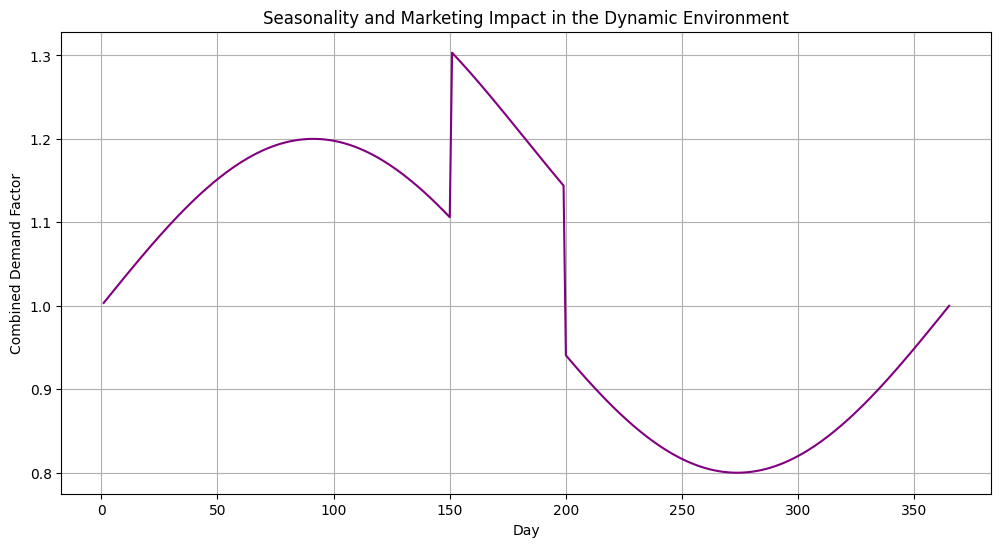

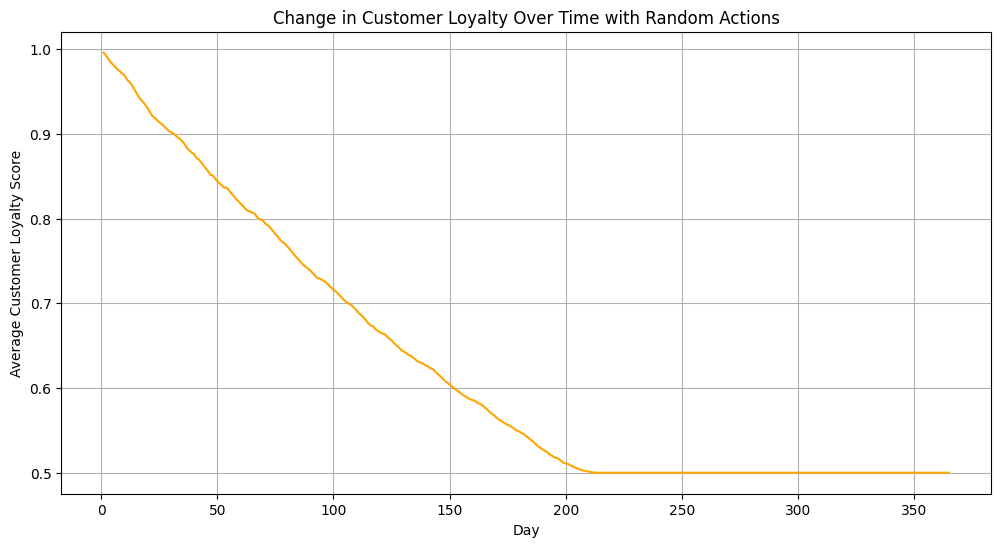

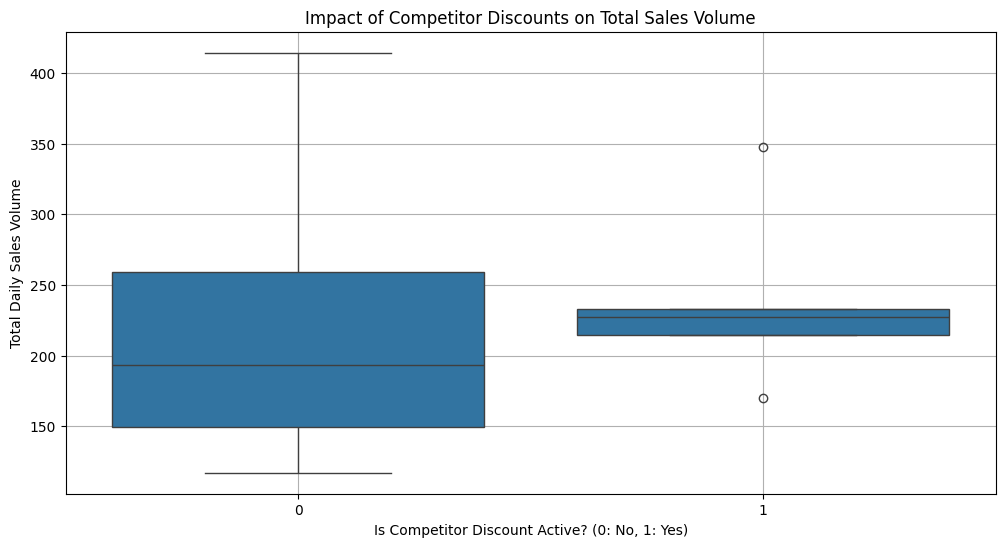

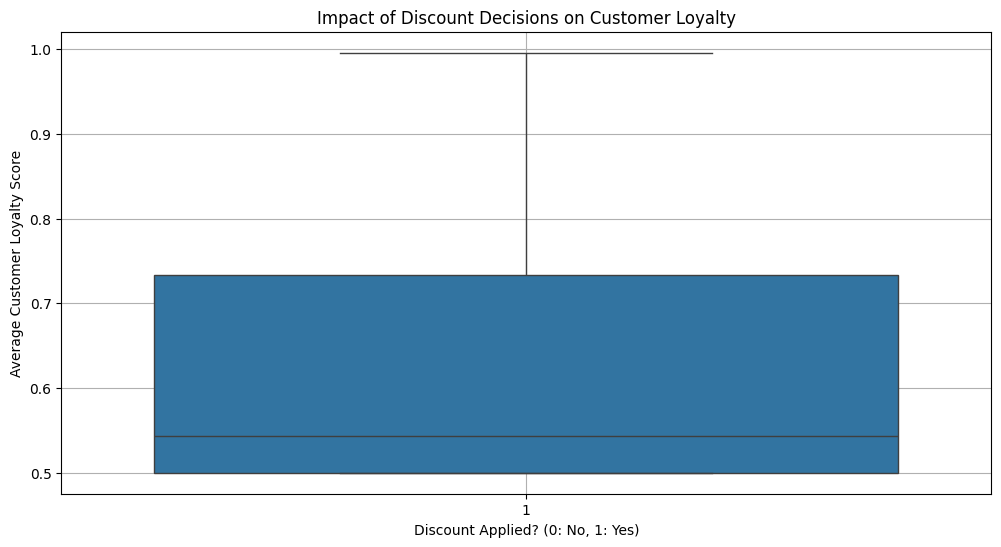

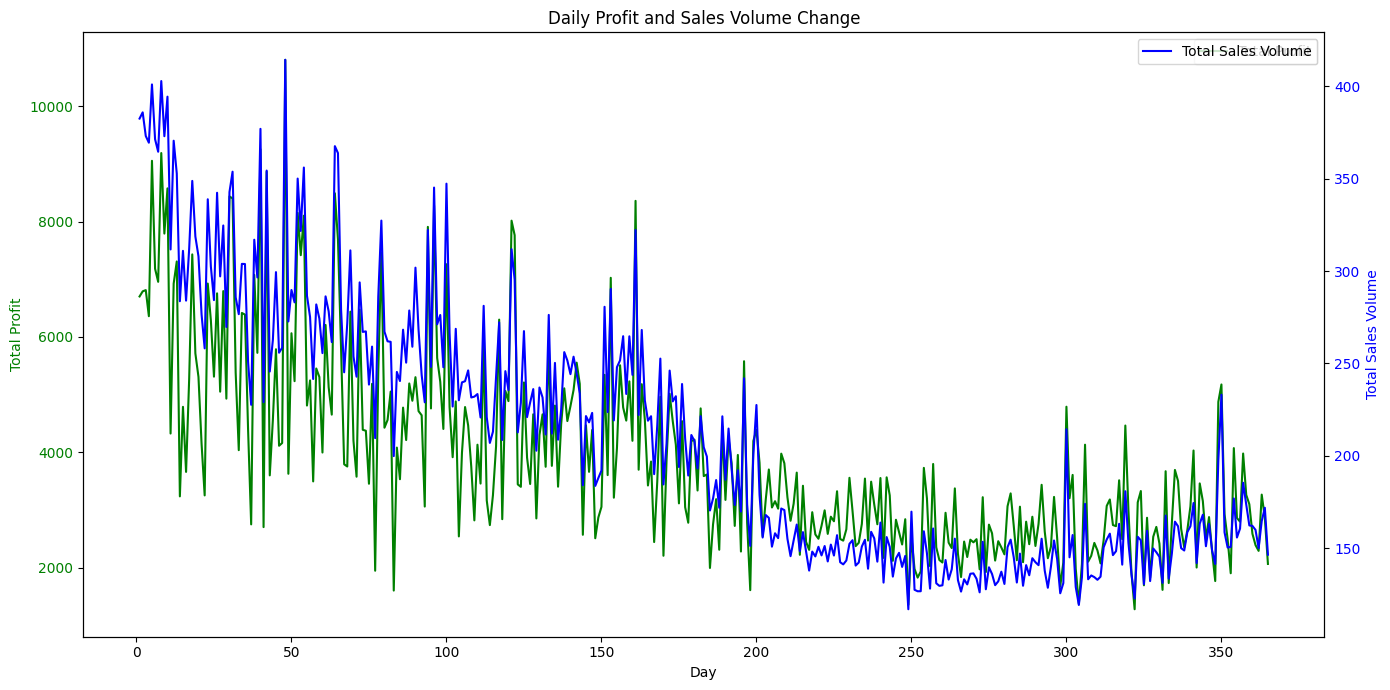

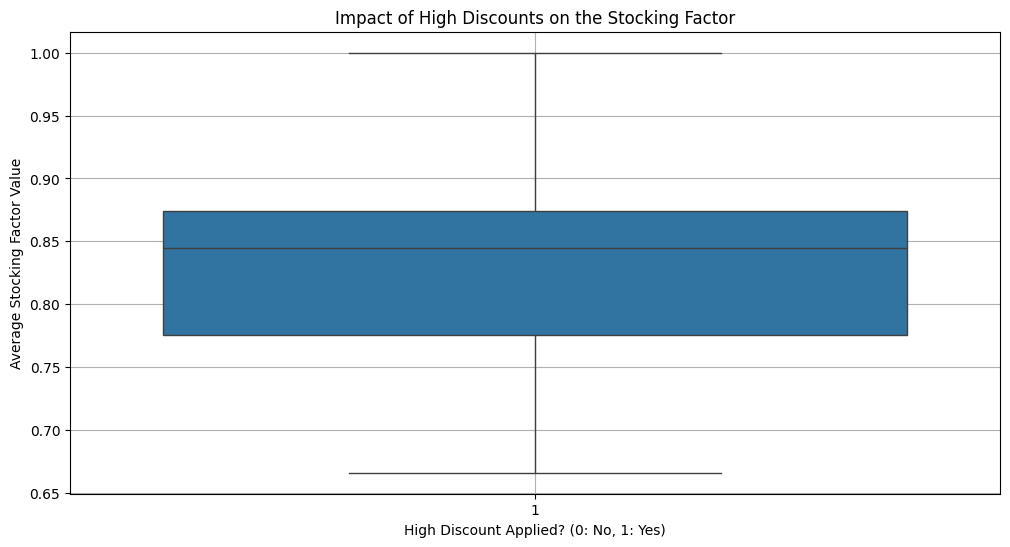

Enhanced environment simulation data saved to 'causal_data.csv'.


In [4]:
# Import necessary libraries
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CausalPricingEnv class definition ---
class CausalPricingEnv(gym.Env):
    """
    Dynamic pricing environment. We've added causal factors to
    the agent's observation space.
    """
    def __init__(self, num_products=5, num_days=365):
        super().__init__()
        self.num_products = num_products
        self.num_days = num_days
        self.current_day = 0

        # Price elasticity: Determines how much discounts affect demand.
        # Negative values indicate that demand increases as price decreases.
        self.price_elasticities = np.random.uniform(-1.5, -0.5, num_products)

        # Base prices and volumes: The base price and daily sales volume for each product.
        self.base_prices = np.random.uniform(20, 100, num_products)
        self.base_volumes = np.random.poisson(100, num_products)

        # Customer loyalty: Initially set to 1.0 for all products.
        self.loyalty_scores = np.ones(num_products)

        # Action space: The decisions the agent can make
        # Determines a discount rate between 0% and 30% for each product.
        self.action_space = spaces.Box(low=0.0, high=0.3, shape=(num_products,), dtype=np.float32)

        # Expanding the observation space:
        # 1 (day) + num_products*30 (past volumes) + num_products (loyalty) + 3 (new factors)
        obs_shape = 1 + num_products * 30 + num_products + 3
        self.observation_space = spaces.Box(
            low=0,
            high=np.inf,
            shape=(obs_shape,),
            dtype=np.float32
        )
        self.past_volumes = np.zeros((num_products, 30))

    def _get_obs(self):
        # This method returns all current values required for the observation space as a single NumPy array
        seasonality_factor = 1 + 0.2 * np.sin(2 * np.pi * self.current_day / self.num_days)
        marketing_factor = 1.2 if 150 < self.current_day < 200 else 1.0
        competitor_discount = 0.2 if (self.current_day % 50 == 0) and (np.random.rand() > 0.5) else 0.0

        return np.concatenate(([self.current_day], self.past_volumes.flatten(), self.loyalty_scores, [seasonality_factor, marketing_factor, competitor_discount]))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_day = 0
        self.past_volumes = np.zeros((self.num_products, 30))
        self.loyalty_scores = np.ones(self.num_products)

        observation = self._get_obs()

        info = {}
        return observation, info

    def step(self, action):
        self.current_day += 1

        # --- Calculate Causal Factors ---
        seasonality_factor = 1 + 0.2 * np.sin(2 * np.pi * self.current_day / self.num_days)
        marketing_factor = 1.2 if 150 < self.current_day < 200 else 1.0
        competitor_discount = 0.2 if (self.current_day % 50 == 0) and (np.random.rand() > 0.5) else 0.0

        # --- Calculate Action and Results ---
        discount_rates = np.clip(action, self.action_space.low, self.action_space.high)
        final_prices = self.base_prices * (1 - discount_rates)

        # Customer loyalty: High discounts decrease loyalty over time
        self.loyalty_scores -= 0.005 * (discount_rates > 0.1) * self.loyalty_scores
        self.loyalty_scores = np.clip(self.loyalty_scores, 0.5, 1.0)

        # Stocking factor: Past high discounts pull demand forward
        past_avg_volumes = np.mean(self.past_volumes, axis=1)
        stocking_factor = 1 - 0.5 * (discount_rates > 0.05) * (past_avg_volumes / self.base_volumes)

        # Calculate sales volume by combining all factors
        sales_volumes = (self.base_volumes * self.loyalty_scores * (1 + self.price_elasticities * (discount_rates - competitor_discount)) * seasonality_factor * stocking_factor *
                         marketing_factor)
        sales_volumes = np.maximum(sales_volumes, 0)

        # Calculate profit and reward
        costs = self.base_prices * 0.6
        profits = (final_prices - costs) * sales_volumes
        reward = np.sum(profits)

        # Update past volumes
        self.past_volumes = np.roll(self.past_volumes, -1, axis=1)
        self.past_volumes[:, -1] = sales_volumes

        # Create new observation and the info dictionary
        observation = self._get_obs()
        terminated = self.current_day >= self.num_days
        truncated = False

        info = {
            'total_profit': np.sum(profits),
            'sales_volumes': sales_volumes,
            'discount_rates': discount_rates,
            'seasonality_factor': seasonality_factor,
            'competitor_discount': competitor_discount,
            'marketing_factor': marketing_factor,
            'loyalty_scores': self.loyalty_scores,
            'stocking_factor': stocking_factor
        }

        return observation, reward, terminated, truncated, info

# --- Test and visualize the environment's dynamics ---
if __name__ == '__main__':
    # ... (The other test and visualization code remains the same)
    # This block was left as-is because it contains no errors.
    num_products = 5
    num_days = 365

    env = CausalPricingEnv(num_products=num_products, num_days=num_days)
    obs, info = env.reset()
    terminated = False

    data_points = []

    while not terminated:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        data_points.append({
            'day': env.current_day,
            'is_discounted': 1 if np.any(info['discount_rates'] > 0.05) else 0,
            'total_sales_volume': np.sum(info['sales_volumes']),
            'total_profit': info['total_profit'],
            'seasonality_factor': info['seasonality_factor'],
            'competitor_discount_active': 1 if info['competitor_discount'] > 0 else 0,
            'marketing_factor_active': 1 if info['marketing_factor'] > 1.0 else 0,
            'avg_loyalty_score': np.mean(info['loyalty_scores']),
            'stocking_factor_value': np.mean(info['stocking_factor'])
        })

    df_causal = pd.DataFrame(data_points)

    # Plot 1: Seasonality and Marketing Impact in the Dynamic Environment
    plt.figure(figsize=(12, 6))
    df_causal['combined_demand_factor'] = df_causal['seasonality_factor'] + (df_causal['marketing_factor_active'] * 0.2)
    sns.lineplot(data=df_causal, x='day', y='combined_demand_factor', color='purple')
    plt.title('Seasonality and Marketing Impact in the Dynamic Environment')
    plt.xlabel('Day')
    plt.ylabel('Combined Demand Factor')
    plt.grid(True)
    plt.show()

    # Plot 2: Long-term Trend of Customer Loyalty
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_causal, x='day', y='avg_loyalty_score', color='orange')
    plt.title('Change in Customer Loyalty Over Time with Random Actions')
    plt.xlabel('Day')
    plt.ylabel('Average Customer Loyalty Score')
    plt.grid(True)
    plt.show()

    # Plot 3: Impact of Competitor Discounts on Sales Volume
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_causal, x='competitor_discount_active', y='total_sales_volume')
    plt.title('Impact of Competitor Discounts on Total Sales Volume')
    plt.xlabel('Is Competitor Discount Active? (0: No, 1: Yes)')
    plt.ylabel('Total Daily Sales Volume')
    plt.grid(True)
    plt.show()

    # Plot 4: Impact of Discount Decisions on Customer Loyalty
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_causal, x='is_discounted', y='avg_loyalty_score')
    plt.title('Impact of Discount Decisions on Customer Loyalty')
    plt.xlabel('Discount Applied? (0: No, 1: Yes)')
    plt.ylabel('Average Customer Loyalty Score')
    plt.grid(True)
    plt.show()

    # Plot 5: Daily Profit and Sales Volume Change
    fig, ax1 = plt.subplots(figsize=(14, 7))

    sns.lineplot(data=df_causal, x='day', y='total_profit', color='green', ax=ax1, label='Total Profit')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Total Profit', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    sns.lineplot(data=df_causal, x='day', y='total_sales_volume', color='blue', ax=ax2, label='Total Sales Volume')
    ax2.set_ylabel('Total Sales Volume', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title('Daily Profit and Sales Volume Change')
    fig.tight_layout()
    plt.show()

    # Plot 6: Impact of High Discounts on the Stocking Factor
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_causal, x='is_discounted', y='stocking_factor_value')
    plt.title('Impact of High Discounts on the Stocking Factor')
    plt.xlabel('High Discount Applied? (0: No, 1: Yes)')
    plt.ylabel('Average Stocking Factor Value')
    plt.grid(True)
    plt.show()

    # Save the data for later parts of the project
    df_causal.to_csv("causal_data.csv", index=False)
    print("Enhanced environment simulation data saved to 'causal_data.csv'.")